<font color='lime'>

# Model training and parameter selection with Grid Search

</font> 

<font color='yellow'>

## Support Vector Machine (SVM)

</font> 

<font color='orange'>

### Load the data

</font> 

In [12]:
import pandas as pd

file_path = 'data/spotify_songs_with_mood.csv'
data = pd.read_csv(file_path)

<font color='orange'>

### Separate to subsets and train 

</font> 

In [13]:
from sklearn.model_selection import train_test_split

# We'll need to separate out the features (X) and the target variable (y)
X = data.drop(['mood'], axis=1)  # all columns except 'mood'
y = data['mood']  # the target variable

# Split the dataset into training (70%) and testing (30%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Shape of the training and testing data
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((20222, 23), (8667, 23), (20222,), (8667,))

<font color='orange'>

### Run the algo

</font> 

In [14]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

# Identifying numerical and categorical columns (excluding 'track_id' which is unique and 'mood' which is the target)
numerical_cols = X_train.select_dtypes(include=['float64', 'int64']).columns.tolist()
categorical_cols = X_train.select_dtypes(include=['object']).columns.tolist()
categorical_cols.remove('track_id')  # We exclude the track_id as it's a unique identifier

# For simplicity, let's use only numerical features for training the Decision Tree model
X_train_numerical = X_train[numerical_cols]
X_test_numerical = X_test[numerical_cols]

# Decision Tree model
dt = DecisionTreeClassifier(random_state=42)

# Parameters for GridSearchCV
params = {
    'max_depth': [10, 20, 30, None],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10]
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=dt, param_grid=params, cv=5, n_jobs=-1, verbose=1)
grid_search.fit(X_train_numerical, y_train)

# Best parameters
best_params = grid_search.best_params_
best_params

Fitting 5 folds for each of 36 candidates, totalling 180 fits


{'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2}

<font color='orange'>

### Save and test

</font> 

In [15]:
# Train the model with the best parameters
best_dt = DecisionTreeClassifier(**best_params, random_state=42)
best_dt.fit(X_train_numerical, y_train)

# Save the model
import joblib

model_filename = 'data/songs_mood_decision_tree_model.joblib'
joblib.dump(best_dt, model_filename)

# Predictions on the test set
y_pred = best_dt.predict(X_test_numerical)

# Calculate the accuracy
accuracy = accuracy_score(y_test, y_pred)
percent_accuracy = accuracy * 100  # convert to percent

model_filename, percent_accuracy

('data/songs_mood_decision_tree_model.joblib', 99.96538594669437)

<font color='yellow'>

## Model estimation

</font> 

<font color='orange'>

### A. Visualization of predicted values

</font> 

<Figure size 1000x1000 with 0 Axes>

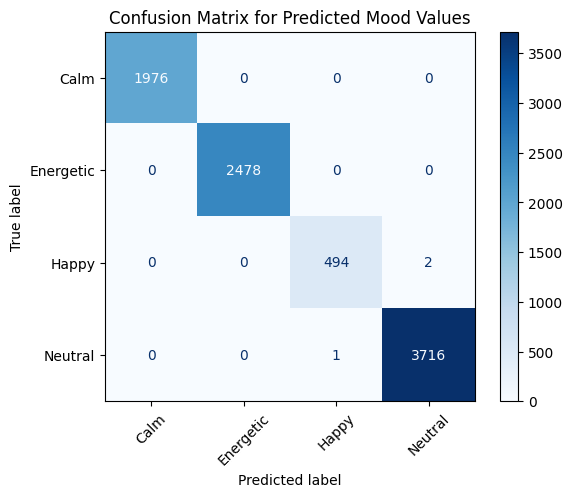

In [19]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=best_dt.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_dt.classes_)

# Plot the confusion matrix
plt.figure(figsize=(10,10))
disp.plot(cmap=plt.cm.Blues)
plt.xticks(rotation=45)
plt.title('Confusion Matrix for Predicted Mood Values')
plt.show()

<font color='orange'>

### B. Prediction quality assessment (precision/recall/f1-score/ROC-AUC)

</font> 

In [20]:
from sklearn.metrics import classification_report

# Calculate precision, recall, and f1-score
class_report = classification_report(y_test, y_pred, output_dict=True)

# Convert to a dataframe for easier visualization
class_report_df = pd.DataFrame(class_report).transpose()
class_report_df

,precision,recall,f1-score,support
Calm,1.000000,1.000000,1.000000,1976.000000
Energetic,1.000000,1.000000,1.000000,2478.000000
Happy,0.997980,0.995968,0.996973,496.000000
Neutral,0.999462,0.999731,0.999597,3717.000000
accuracy,0.999654,0.999654,0.999654,0.999654
macro avg,0.999360,0.998925,0.999142,8667.000000
weighted avg,0.999654,0.999654,0.999654,8667.000000


<font color='orange'>

### C. Visualization of the decision tree

</font> 

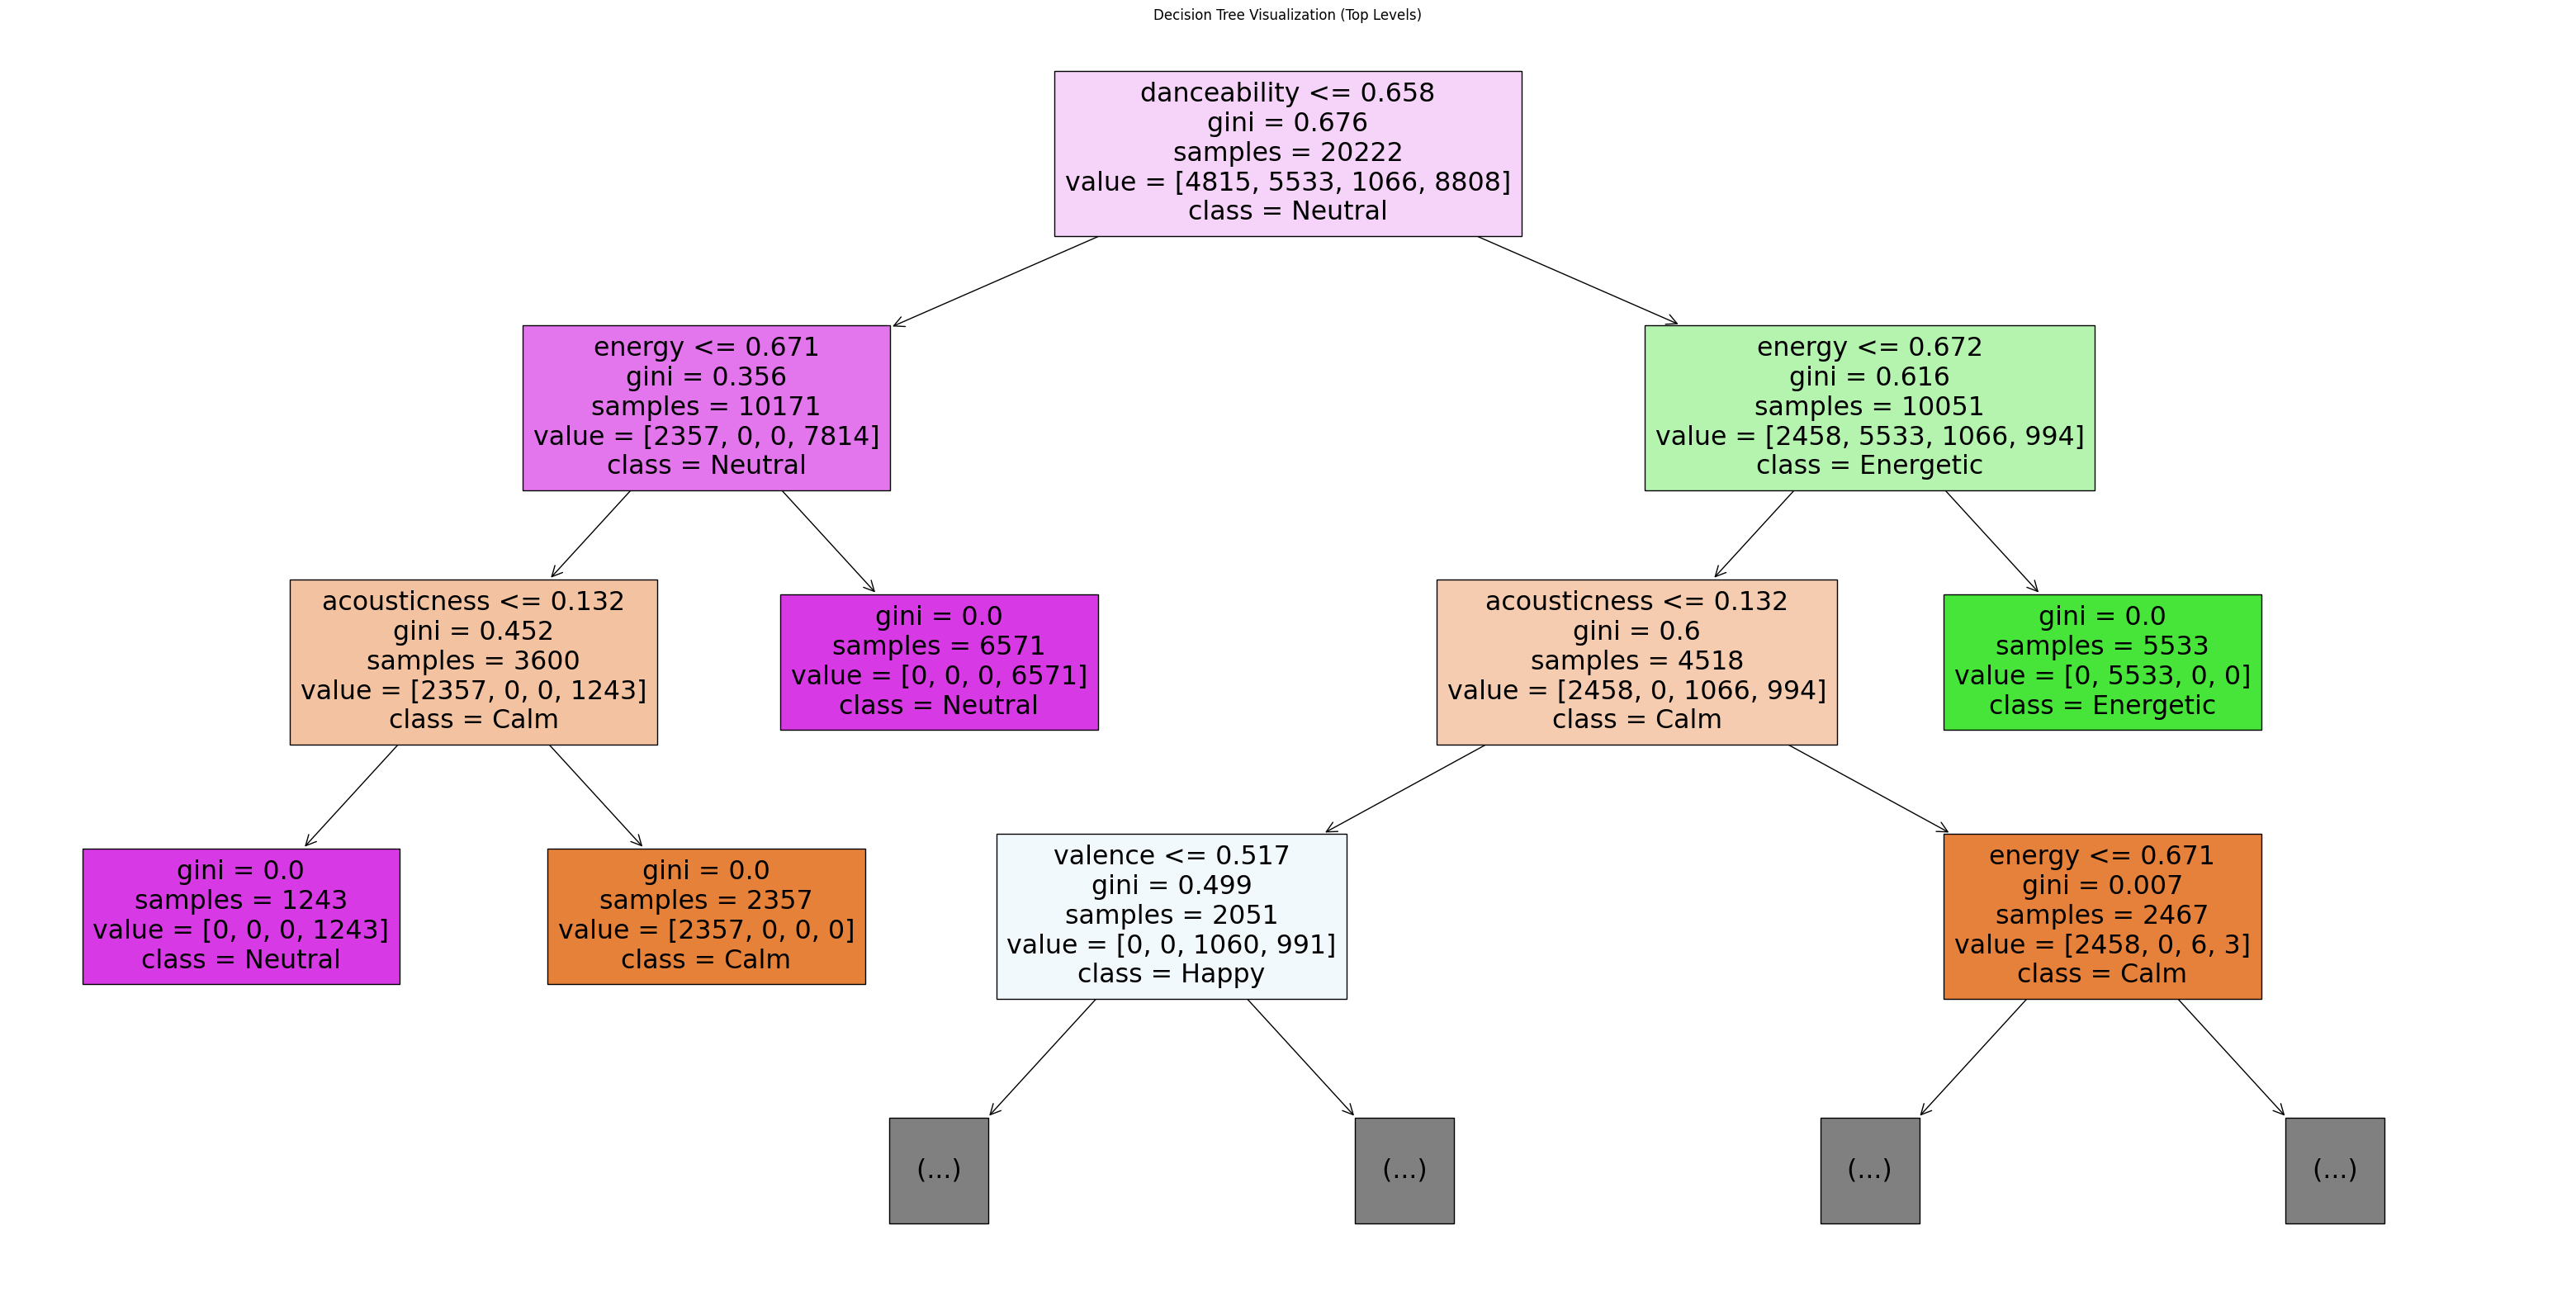

In [24]:
from sklearn.tree import plot_tree

# Visualize the top levels of the Decision Tree
plt.figure(figsize=(40,20))
plot_tree(best_dt, filled=True, feature_names=numerical_cols, class_names=best_dt.classes_, max_depth=3)
plt.title('Decision Tree Visualization (Top Levels)')
plt.show()